# 楽曲分析(フレーム分析)

## 必要なライブラリのインポート

In [1]:
# ファイルを開いたら一番最初に実行してください
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import IPython
import pandas as pd
import time
import seaborn as sns
import umap

from keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dense, Dropout, Attention, Concatenate

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

from skmultilearn.model_selection import IterativeStratification

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/kenta4610/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-01 11:43:59.216940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## データの読み込み & 加工

In [2]:
# 各曲ごとに特徴量を結合するための関数
def create_feature_array(df):
    feature_arrays = []
    labels = []
    unique_songs = df['Name'].unique()
    
    for song in unique_songs:
        song_df = df[df['Name'] == song]
        
        # 特徴量を抽出してNumPy配列に変換
        features = song_df.drop(columns=['Name', 'Label', 'Feature']).values
        # 特徴量が横方向に並ぶように変形 (時間ステップ, 特徴量数)
        features_reshaped = features.T
        # リストに追加
        feature_arrays.append(features_reshaped)
        # ラベルを追加 (すべての特徴量で同じなので、最初のラベルを使用)
        labels.append(song_df['Label'].iloc[0])
    
    return np.array(feature_arrays), np.array(labels)

# 10秒のフレームを1秒ずつ動かす
def split_frames(X, frame_length=430, step=43):
    num_samples, time_steps, num_features = X.shape
    frames = []
    
    for start in range(0, time_steps - frame_length + 1, step):
        end = start + frame_length
        frames.append(X[:, start:end, :].astype('float16'))

    return np.array(frames)

In [3]:
file_paths = ['joyful_data.csv', 'fearful_data.csv', 'sorrowful_data.csv', 'relaxing_data.csv']
data_list = [pd.read_csv('./feature_data/'+file_path) for file_path in file_paths]
df = pd.concat(data_list, ignore_index=True)
df = df.fillna(0)

In [4]:
# 各特徴量に対して正規化を適用
scaler = StandardScaler()
feature_names = df['Feature'].unique()
for feature in feature_names:
    if feature != 'Spectral':
        tmp = df[df['Feature'] == feature].iloc[:, 3:]
        normalized_tmp = scaler.fit_transform(tmp)
        df.loc[df['Feature'] == feature, df.columns[3:]] = normalized_tmp

# 特徴量とラベルを整形
X, y = create_feature_array(df)
# データの形状を確認
print(X.shape, y.shape)

(200, 2584, 113) (200,)


In [5]:
seed = 57  # 再現可能なシード
X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,  # テストセットの割合
        random_state=seed,  # 再現性のための乱数シード
        stratify=y  # 層化抽出法を適用
    )

X_train_frame = split_frames(X_train)
X_train_frame = X_train_frame.transpose(1, 0, 2, 3)
X_train_frame = X_train_frame.reshape(-1, 430, 113)
y_train_frame = np.repeat(y_train, 51)

X_test_frame = split_frames(X_test)
X_test_frame = X_test_frame.transpose(1, 0, 2, 3)
X_test_frame = X_test_frame.reshape(-1, 430, 113)
y_test_frame = np.repeat(y_test, 51)

print(X_train_frame.shape, y_train_frame.shape)
print(X_test_frame.shape, y_test_frame.shape)

(7140, 430, 113) (7140,)
(3060, 430, 113) (3060,)


## モデルを生成する

In [10]:
# モデルの生成
# start = time.time()
# for i in range(100):
#     print('GRUモデル', i+1, 'を構築中')
#     seed = np.random.randint(0, 10000)  # ランダムなシード
#     # データセットの分割（層化抽出法を使用）
#     X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
#         X_train_frame, y_train_frame, 
#         test_size=0.2,
#         random_state=seed,
#         stratify=y_train_frame
#     )
    
#     y_train_binary = to_categorical(y_train_tmp, num_classes=4)
    
#     # モデルの構築
#     model = Sequential([
#         GRU(50, input_shape=(X_train_tmp.shape[1], X_train_tmp.shape[2]), return_sequences=True),
#         Dropout(0.2),
#         GRU(50, return_sequences=False),
#         Dense(4, activation='sigmoid')
#     ])

#     # モデルのコンパイル
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     # モデルのトレーニング
#     model.fit(X_train_tmp, y_train_binary, epochs=10, batch_size=32, verbose=0)

#     # モデルの保存
#     model.save(f'gru_model_57/model_{i+1}.h5')
#     end = time.time()
#     print('経過時間: ', end - start, '秒')

GRUモデル 1 を構築中
経過時間:  5913.268923044205 秒
GRUモデル 2 を構築中
経過時間:  6250.800883054733 秒
GRUモデル 3 を構築中
経過時間:  6584.961271047592 秒
GRUモデル 4 を構築中
経過時間:  6920.978266000748 秒
GRUモデル 5 を構築中
経過時間:  7255.161684036255 秒
GRUモデル 6 を構築中
経過時間:  7591.152568101883 秒
GRUモデル 7 を構築中
経過時間:  7926.127633094788 秒
GRUモデル 8 を構築中
経過時間:  8261.707915067673 秒
GRUモデル 9 を構築中
経過時間:  8596.184397220612 秒
GRUモデル 10 を構築中
経過時間:  8930.641602993011 秒
GRUモデル 11 を構築中
経過時間:  9264.85904121399 秒
GRUモデル 12 を構築中
経過時間:  9601.229503154755 秒
GRUモデル 13 を構築中
経過時間:  9935.650042057037 秒
GRUモデル 14 を構築中
経過時間:  10268.639909982681 秒
GRUモデル 15 を構築中
経過時間:  10602.57317996025 秒
GRUモデル 16 を構築中
経過時間:  10937.11170911789 秒
GRUモデル 17 を構築中
経過時間:  11271.992247104645 秒
GRUモデル 18 を構築中
経過時間:  11606.350574016571 秒
GRUモデル 19 を構築中
経過時間:  11939.83618593216 秒
GRUモデル 20 を構築中
経過時間:  12272.866266012192 秒
GRUモデル 21 を構築中
経過時間:  12606.68605709076 秒
GRUモデル 22 を構築中
経過時間:  12940.07795214653 秒
GRUモデル 23 を構築中
経過時間:  13274.186763048172 秒
GRUモデル 24 を構築中
経過時間:  13608.23492908477

In [18]:
# 予測の実行
def predict_emotions(X, model_folder):
    results = []
    for i in range(1, 101): # 100個のモデルに対して
        model = load_model(f'{model_folder}/model_{i}.h5')
        predictions = model.predict(X)
        results.append(predictions)
    return np.array(results)

def reshape_data(X):
    size = int(X.shape[1] / 51)
    reshaped = X.reshape(100, size, 51, 4)
    return reshaped.transpose(1, 3, 2, 0)

def create_average_data(X, n):
    indices = np.random.choice(X.shape[3], n, replace=False)
    selected_data = X[..., indices]
    return np.mean(selected_data, axis=3)

In [20]:
# LSTMとGRUモデルで訓練データを予測
pred_train_lstm = predict_emotions(X_train_frame, 'lstm_model_57')
prob_train_lstm = reshape_data(pred_train_lstm)
pred_train_gru = predict_emotions(X_train_frame, 'gru_model_57')
prob_train_gru = reshape_data(pred_train_gru)

# LSTMとGRUモデルでテストデータを予測
pred_test_lstm = predict_emotions(X_test_frame, 'lstm_model_57')
prob_test_lstm = reshape_data(pred_test_lstm)
pred_test_gru = predict_emotions(X_test_frame, 'gru_model_57')
prob_test_gru = reshape_data(pred_test_gru)

96/96 [==============================] - 7s 67ms/step


In [21]:
ave_train_lstm = create_average_data(prob_train_lstm, 100)
ave_train_gru = create_average_data(prob_train_gru, 100)
ave_test_lstm = create_average_data(prob_test_lstm, 100)
ave_test_gru = create_average_data(prob_test_gru, 100)

In [ ]:
# n = 100
# indices = np.random.choice(prob_lstm.shape[3], n, replace=False)
# selected_data = prob_lstm[..., indices]
# ave_prob = np.mean(selected_data, axis=3)

# # music_data: 2次元配列、形状は (感情ラベル数, フレーム数)
# music_data = ave_prob[3]

# joyful_prob = music_data[0]
# fearful_prob = music_data[1]
# sorrowful_prob = music_data[2]
# relaxing_prob = music_data[3]

# # 感情の確率のプロット
# plt.figure(figsize=(12, 2.5))
# plt.plot(joyful_prob, label='Joyful')
# plt.plot(fearful_prob, label='Fearful')
# plt.plot(sorrowful_prob, label='Sorrowful')
# plt.plot(relaxing_prob, label='Relaxing')
# plt.xlabel('Frame')
# plt.ylabel('Probability')
# plt.show()

## 予測した感情の確率から楽曲がどの感情に分類されるかを学習・予測・評価

In [25]:
# 正解率を保存するリスト
train_data_list = [ave_train_lstm, ave_train_gru]
test_data_list = [ave_test_lstm, ave_test_gru]
layer_list = [LSTM(50, input_shape=(4, 51), return_sequences=False),
               GRU(50, input_shape=(4, 51), return_sequences=False)]
n_list = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

acc = []
# one-hot表現に変換
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

for layer in layer_list:
    # モデルの構築、コンパイル、トレーニング
    model_3 = Sequential([
        layer,
        Dense(4, activation='softmax')
    ])
    model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    for train_data in train_data_list:
        model_3.fit(train_data, y_train_one_hot, epochs=10, batch_size=32, verbose=0)
        for test_data in test_data_list:
            # 予測と正解率の計算
            y_pred = model_3.predict(test_data, verbose=0)
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_test_classes = np.argmax(y_test_one_hot, axis=1)
            accuracy = accuracy_score(y_test_classes, y_pred_classes)

            # 正解率をリストに保存
            acc.append(accuracy)

In [26]:
print(acc)

[0.5333333333333333, 0.5333333333333333, 0.5, 0.5166666666666667, 0.5333333333333333, 0.5, 0.5, 0.5166666666666667]


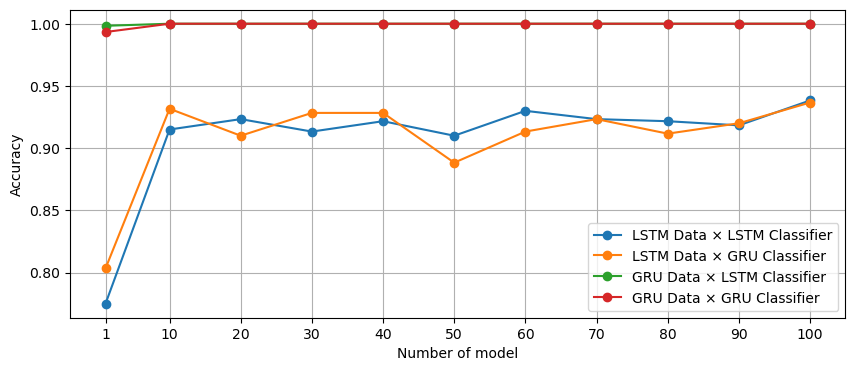

In [59]:
lstm_model_lstm_train_lstm_test = acc[0]
lstm_model_lstm_train_gru_test = acc[1]
lstm_model_gru_train_lstm_test = acc[2]
lstm_model_gru_train_gru_test = acc[3]
gru_model_lstm_train_lstm_test = acc[4]
gru_model_lstm_train_gru_test = acc[5]
gru_model_gru_train_lstm_test = acc[6]
gru_model_gru_train_gru_test = acc[7]

plt.figure(figsize=(10, 4))  # グラフのサイズを調整
plt.plot(n_list, lstm_data_lstm_model, label='LSTM Data × LSTM Classifier', marker='o')
plt.plot(n_list, lstm_data_gru_model, label='LSTM Data × GRU Classifier', marker='o')
plt.plot(n_list, gru_data_lstm_model, label='GRU Data × LSTM Classifier', marker='o')
plt.plot(n_list, gru_data_gru_model, label='GRU Data × GRU Classifier', marker='o')
plt.xlabel('Number of model')
plt.ylabel('Accuracy')
plt.xticks(n_list)  # X軸の目盛りをn_listの値に設定
plt.legend()
plt.grid(True)  # グリッドの表示
plt.show()